In [367]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR

from statsmodels.graphics.api import qqplot
%matplotlib inline
import pickle

Reading The Data

In [318]:
#Reading the Data From The File

resource_data=pd.read_csv("D:\Time Series Assignmant\group_1_1b6ffb4a-b7bc-48d0-ab60-b43f64b7c6f4\mem.log",sep=":",header=None,names=['timestamp','Utilization']) # This is a free datset

In [319]:
resource_data.shape

(47046, 2)

# Modeling The Data 
We are adding the columns of CPU and Memory Utilization 

In [320]:
resource_data[['Memory Allocated','Memory Used','CPU Allocated','CPU Used','Network bandwidth utilization','Storage space utilization']]=resource_data.Utilization.apply(lambda x: pd.Series(str(x).split(":")))

In [321]:
resource_data.head()

,timestamp,Utilization,Memory Allocated,Memory Used,CPU Allocated,CPU Used,Network bandwidth utilization,Storage space utilization
0,Wed Aug 28 16:59:45 IST 2019,65664:65435:14:0.30:0.00:4014G,65664,65435,14,0.30,0.00,4014G
1,Wed Aug 28 17:02:28 IST 2019,65664:65435:14:0.31:0.00:4014G,65664,65435,14,0.31,0.00,4014G
2,Wed Aug 28 17:05:32 IST 2019,65664:65435:14:0.32:0.00:4014G,65664,65435,14,0.32,0.00,4014G
3,Wed Aug 28 17:08:27 IST 2019,65664:65435:14:0.29:0.00:4014G,65664,65435,14,0.29,0.00,4014G
4,Wed Aug 28 17:11:47 IST 2019,65664:65435:14:0.28:0.00:4014G,65664,65435,14,0.28,0.00,4014G


In [325]:
# Dropping The Utilizatiojn Column After Splitting it
resource_data.drop(['Utilization'],axis=1,inplace=True)
resource_data['Storage space utilization']=resource_data['Storage space utilization'].apply(lambda x: str(x[:len(x)-1])) #Removin #Removing the Last Aplphabet To Make the Intrger

In [326]:
resource_data.head()

,timestamp,Memory Allocated,Memory Used,CPU Allocated,CPU Used,Network bandwidth utilization,Storage space utilization
0,Wed Aug 28 16:59:45 IST 2019,65664,65435,14,0.30,0.00,4014
1,Wed Aug 28 17:02:28 IST 2019,65664,65435,14,0.31,0.00,4014
2,Wed Aug 28 17:05:32 IST 2019,65664,65435,14,0.32,0.00,4014
3,Wed Aug 28 17:08:27 IST 2019,65664,65435,14,0.29,0.00,4014
4,Wed Aug 28 17:11:47 IST 2019,65664,65435,14,0.28,0.00,4014


In [327]:
resource_data['timestamp']=pd.to_datetime(resource_data['timestamp']) #Converting Data To TimeStamp

C:\Users\bhanup2\Anaconda3\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname IST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [328]:
#Change The Data Type as 
resource_data['Memory Used']=resource_data['Memory Used'].astype('int')
resource_data['Memory Allocated']=resource_data['Memory Allocated'].astype('int')
resource_data['CPU Used']=resource_data['CPU Used'].astype('float')
resource_data['CPU Allocated']=resource_data['CPU Allocated'].astype('int')
resource_data['Storage space utilization']=resource_data['Storage space utilization'].astype('int')
resource_data['Network bandwidth utilization']=resource_data['Network bandwidth utilization'].astype('float')
resource_data.dtypes

timestamp                        datetime64[ns]
Memory Allocated                          int32
Memory Used                               int32
CPU Allocated                             int32
CPU Used                                float64
Network bandwidth utilization           float64
Storage space utilization                 int32
dtype: object

In [329]:
resource_data.set_index('timestamp',inplace=True) # Seeting Time Stamp To The Index Column

# Data Pre Processing 
we are pre Processing the data fro Training the Algorithm

In [330]:
resource_data.dtypes

Memory Allocated                   int32
Memory Used                        int32
CPU Allocated                      int32
CPU Used                         float64
Network bandwidth utilization    float64
Storage space utilization          int32
dtype: object

In [331]:
resource_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47046 entries, 2019-08-28 16:59:45 to 2020-06-23 19:41:54
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Memory Allocated               47046 non-null  int32  
 1   Memory Used                    47046 non-null  int32  
 2   CPU Allocated                  47046 non-null  int32  
 3   CPU Used                       47046 non-null  float64
 4   Network bandwidth utilization  47046 non-null  float64
 5   Storage space utilization      47046 non-null  int32  
dtypes: float64(2), int32(4)
memory usage: 1.8 MB


There are no Null Values 

In [332]:
resource_data.nunique()  # There are some values with Constant Values we have to remove them to train our data

Memory Allocated                   2
Memory Used                      347
CPU Allocated                      1
CPU Used                         457
Network bandwidth utilization      1
Storage space utilization          1
dtype: int64

# Plotting The Grapphs

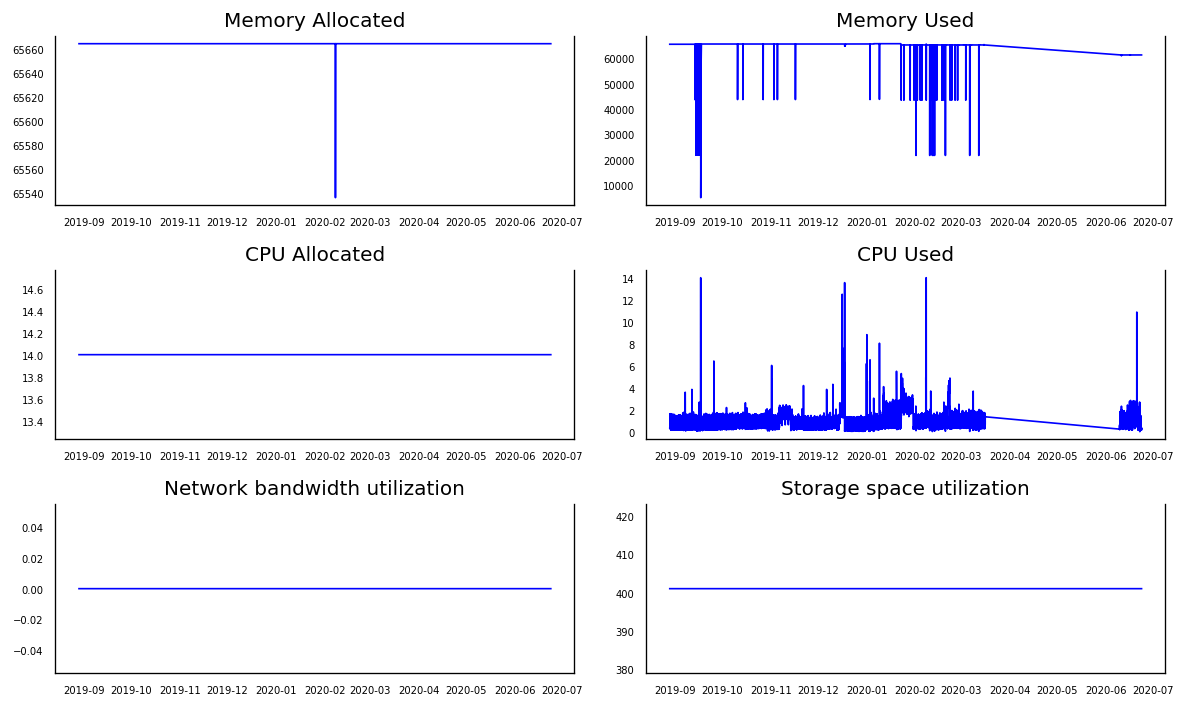

In [308]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = resource_data[resource_data.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(resource_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

We Can See some Values are constant , We need to drop them 

In [333]:
processed_data=resource_data.copy()

In [335]:
for column in resource_data.columns:
    constant_column=[InternetShortcut]
    resource_data[column].nunique()
    if constant_column==1:
        processed_data.drop([column],axis=1,inplace=True)     

In [336]:
processed_data.head()

,Memory Allocated,Memory Used,CPU Used
timestamp,,,
2019-08-28 16:59:45,65664,65435,0.30
2019-08-28 17:02:28,65664,65435,0.31
2019-08-28 17:05:32,65664,65435,0.32
2019-08-28 17:08:27,65664,65435,0.29
2019-08-28 17:11:47,65664,65435,0.28


# Training  The Model

In [342]:
nobs = 3000
resource_train, resource_test = processed_data[0:-nobs], processed_data[-nobs:]

# Splitting The Data in Train and test 
print(resource_train.shape)  
print(resource_test.shape)  

(44046, 3)
(3000, 3)


In [344]:
#adfuller_test is used to predict the Stationary of data

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [346]:
for name, column in resource_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Memory Allocated" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -209.869
 No. Lags Chosen       = 0
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Memory Used" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -22.3371
 No. Lags Chosen       = 53
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPU Used" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signi

We can see Our Series Is stationary We dont need to make it Stationary

In [347]:
## Using VAR Model Forecast Our Data , We are searching for the best lag where our data is showing less AIC 

model = VAR(resource_train)
for i in [1,2,3,4,5,10,15,25]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\bhanup2\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Lag Order = 1
AIC :  11.324881837198358
BIC :  11.327250224198258
FPE :  82857.85574090808
HQIC:  11.325628120997182 

Lag Order = 2
AIC :  11.151956078738237
BIC :  11.156100839265845
FPE :  69700.03359524441
HQIC:  11.15326210301351 

Lag Order = 3
AIC :  11.09590141434996
BIC :  11.101822619791283
FPE :  65900.5070288251
HQIC:  11.097767202783972 

Lag Order = 4
AIC :  11.045460684859686
BIC :  11.053158406605283
FPE :  62658.87967458889
HQIC:  11.047886261136277 

Lag Order = 5
AIC :  11.038757208107587
BIC :  11.048231517552559
FPE :  62240.25203212981
HQIC:  11.041742595912146 

Lag Order = 10
AIC :  11.014426490730695
BIC :  11.032784809758256
FPE :  60744.176190375576
HQIC:  11.020211291510122 

Lag Order = 15
AIC :  10.997784978030262
BIC :  11.025029092200246
FPE :  59741.666084650686
HQIC:  11.006369784151634 

Lag Order = 25
AIC :  10.977569792846086
BIC :  11.0225908562559
FPE :  58546.10269697477
HQIC:  10.991756387527603 



We can see after lag 5 our data is reducing Error very Slowly we will use lag as 5

In [348]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 16, Jul, 2020
Time:                     13:47:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.0482
Nobs:                     44041.0    HQIC:                   11.0417
Log likelihood:          -430505.    FPE:                    62240.3
AIC:                      11.0388    Det(Omega_mle):         62172.5
--------------------------------------------------------------------
Results for equation Memory Allocated
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                   65652.658481       700.269852           93.753           0.000
L1.Memory Allocated         0.000342         0.004864            0.070           0.944
L1.Memory Used           

# Prediction

In [349]:
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = resource_train.values[-lag_order:]
forecast_input

5


array([[6.5664e+04, 6.5168e+04, 3.5000e-01],
       [6.5664e+04, 6.5165e+04, 3.6000e-01],
       [6.5664e+04, 6.5170e+04, 3.7000e-01],
       [6.5664e+04, 6.5169e+04, 3.3000e-01],
       [6.5664e+04, 6.5158e+04, 3.5000e-01]])

In [350]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index= processed_data.index[-nobs:], columns=processed_data.columns)
df_forecast.head()

,Memory Allocated,Memory Used,CPU Used
timestamp,,,
2020-03-06 19:01:13,65663.994760,65291.472007,0.389185
2020-03-06 19:16:30,65663.994780,65331.788864,0.411596
2020-03-06 19:31:31,65663.995338,65362.754072,0.428794
2020-03-06 19:43:33,65663.995297,65394.792177,0.445969
2020-03-06 19:57:32,65663.995247,65428.941665,0.465238


In [351]:
for column in resource_data.columns:
    constant_column=resource_data[column].nunique()
    if constant_column==1:
        df_forecast[column]=resource_data[column]

In [352]:
df_forecast.head()

,Memory Allocated,Memory Used,CPU Used,CPU Allocated,Network bandwidth utilization,Storage space utilization
timestamp,,,,,,
2020-03-06 19:01:13,65663.994760,65291.472007,0.389185,14,0.0,4014
2020-03-06 19:16:30,65663.994780,65331.788864,0.411596,14,0.0,4014
2020-03-06 19:31:31,65663.995338,65362.754072,0.428794,14,0.0,4014
2020-03-06 19:43:33,65663.995297,65394.792177,0.445969,14,0.0,4014
2020-03-06 19:57:32,65663.995247,65428.941665,0.465238,14,0.0,4014


Plotting The difference

In [355]:
df_forecast.rename(columns={'Memory Allocated':'Memory Allocated_f','Memory Used':'Memory Used_f','CPU Used':'CPU Used_f'},inplace=True)

In [356]:
df_forecast.head()

,Memory Allocated_f,Memory Used_f,CPU Used_f,CPU Allocated,Network bandwidth utilization,Storage space utilization
timestamp,,,,,,
2020-03-06 19:01:13,65663.994760,65291.472007,0.389185,14,0.0,4014
2020-03-06 19:16:30,65663.994780,65331.788864,0.411596,14,0.0,4014
2020-03-06 19:31:31,65663.995338,65362.754072,0.428794,14,0.0,4014
2020-03-06 19:43:33,65663.995297,65394.792177,0.445969,14,0.0,4014
2020-03-06 19:57:32,65663.995247,65428.941665,0.465238,14,0.0,4014


In [357]:
final_df=pd.concat([df_forecast,resource_test])

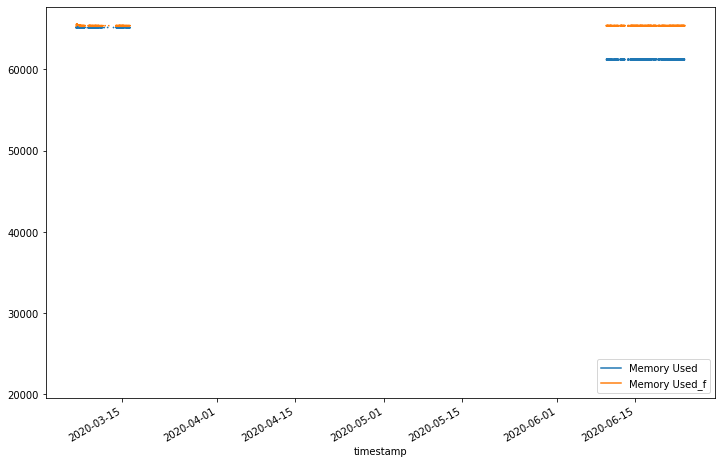

In [358]:
final_df[['Memory Used', 'Memory Used_f']].plot(figsize=(12, 8)) 

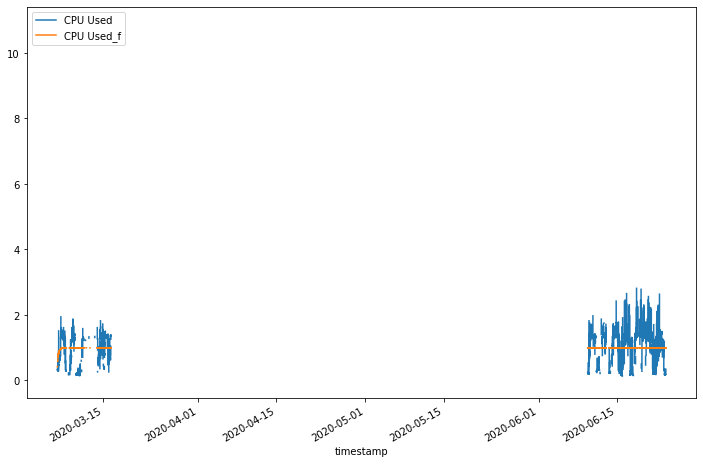

In [360]:
final_df[['CPU Used', 'CPU Used_f']].plot(figsize=(12, 8)) 

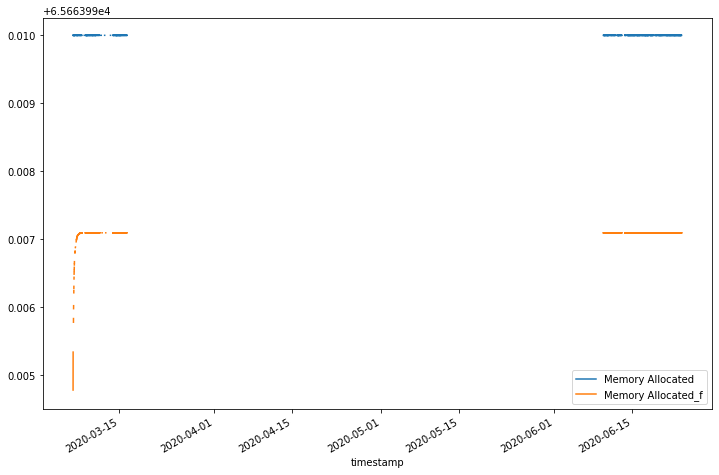

In [361]:
final_df[['Memory Allocated', 'Memory Allocated_f']].plot(figsize=(12, 8)) 

In [368]:
#Making The Pickle File

filename = 'Instance1'
outfile = open(filename,'wb')

In [369]:
pickle.dump(model_fitted,outfile)
outfile.close()